In [1]:
import sys
sys.path.append("..")
import download_utils
import tensorflow as tf
#import keras
from tensorflow import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
L = keras.layers
K = keras.backend
import tqdm
import utils
import time
import zipfile
import json
from collections import defaultdict
import re
import random
from random import choice
import os
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from collections import Counter

/Users/jiahuiyuan/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Extract image features (Xception)

In [2]:
IMG_SIZE = 299
def get_cnn_encoder():
    K.set_learning_phase(False)
    #Use the pretrained Xception model 
    model = keras.applications.Xception(include_top=False)
    #normalize features
    preprocess_for_model = keras.applications.xception.preprocess_input
    
    #apply GlobalAveragePooling2D to get 1x1x2048 and use it as an embedding of an image
    model = keras.models.Model(model.inputs, keras.layers.GlobalAveragePooling2D()(model.output))
    return model, preprocess_for_model

In [3]:
# load prepared embeddings
train_img_embeds = utils.read_pickle("train_img_embeds.pickle")
train_img_fns = utils.read_pickle("train_img_fns.pickle")
val_img_embeds = utils.read_pickle("val_img_embeds.pickle")
val_img_fns = utils.read_pickle("val_img_fns.pickle")
# check shapes
print(train_img_embeds.shape, len(train_img_fns))
print(val_img_embeds.shape, len(val_img_fns))

(82783, 2048) 82783
(40504, 2048) 40504


In [4]:
# check prepared samples of images
list(filter(lambda x: x.endswith("_sample.zip"), os.listdir(".")))

['val2014_sample.zip', 'train2014_sample.zip']

## Prepare Captions

In [5]:
# extract captions from zip
def get_captions_for_fns(fns, zip_fn, zip_json_path):
    zf = zipfile.ZipFile(zip_fn)
    j = json.loads(zf.read(zip_json_path).decode("utf8"))
    id_to_fn = {img["id"]: img["file_name"] for img in j["images"]}
    fn_to_caps = defaultdict(list)
    for cap in j['annotations']:
        fn_to_caps[id_to_fn[cap['image_id']]].append(cap['caption'])
    fn_to_caps = dict(fn_to_caps)
    return list(map(lambda x: fn_to_caps[x], fns))
    
train_captions = get_captions_for_fns(train_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_train2014.json")

val_captions = get_captions_for_fns(val_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_val2014.json")

# check shape
print(len(train_img_fns), len(train_captions))
print(len(val_img_fns), len(val_captions))

82783 82783
40504 40504


In [6]:
# split sentence into tokens (split into lowercased words)
def split_sentence(sentence):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', sentence.lower())))

In [7]:
# special tokens
PAD = "#PAD#"
UNK = "#UNK#"
START = "#START#"
END = "#END#"

def generate_vocabulary(train_captions):
    """
    Return {token: index} for all train tokens (words) that occur 5 times or more 
    Also add PAD (for batch padding), UNK (unknown, out of vocabulary), 
        START (start of sentence) and END (end of sentence) tokens into the vocabulary.
    """
    flattened = [sentence for captions in train_captions for sentence in captions]
    flattened = split_sentence(' '.join(flattened))
    counter = Counter(flattened)
    vocab = [token for token, count in counter.items() if count >= 5]
    vocab += [PAD, UNK, START, END]
    return {token: index for index, token in enumerate(sorted(vocab))}

#convert each caption of each image to a list of indices based on {token: index}
#vocab = generate_vocabulary(train_captions)
def caption_tokens_to_indices(captions, vocab): 
    inds = [[
        [vocab[START]] + 
        [vocab[token] if token in vocab else vocab[UNK] for token in split_sentence(sentence)] 
        + [vocab[END]] 
            for sentence in caption] 
        for caption in captions]
    
    return inds

# prepare vocabulary
vocab = generate_vocabulary(train_captions)
vocab_inverse = {idx: w for w, idx in vocab.items()}

# replace tokens with indices
train_captions_indexed = caption_tokens_to_indices(train_captions, vocab)
val_captions_indexed = caption_tokens_to_indices(val_captions, vocab)

# used for training
def batch_captions_to_matrix(batch_captions, pad_idx, max_len=None):
    """
    'batch_captions' is an array of arrays, i.e. train_captions_indexed[0]
    'pad_idx' = vocab[PAD]
    """
    
    if max_len == None:
        max_len = len(max(batch_captions, key=lambda x:len(x)))
    else:
        max_len = min(max_len, len(max(batch_captions, key=lambda x:len(x))))
    
    matrix = [[index for index in captions[:max_len]] + [pad_idx]* (max(max_len-len(captions),0))
              for captions in batch_captions]
    
    return np.array(matrix)

## Decoder Architecture -- LSTM

In [8]:
tf.reset_default_graph()
tf.set_random_seed(1)
s = tf.InteractiveSession()

IMG_EMBED_SIZE = train_img_embeds.shape[1]
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
LSTM_UNITS = 300
LOGIT_BOTTLENECK = 120
pad_idx = vocab[PAD]

In [9]:
class decoder:
    ### input placeholders ###
    img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
    sentences = tf.placeholder('int32', [None, None])
    
    ### image & embedding feature layers ###
    img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, 
                                      input_shape=(None, IMG_EMBED_SIZE), 
                                      activation='elu')
    img_embed_bottleneck_to_h0 = L.Dense(LSTM_UNITS,
                                         input_shape=(None, IMG_EMBED_BOTTLENECK),
                                         activation='elu')
    word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)
    
    ### LSTM cell structure ###
    lstm = tf.nn.rnn_cell.LSTMCell(LSTM_UNITS)
    token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, 
                                      input_shape=(None, LSTM_UNITS),
                                      activation="elu")
    token_logits = L.Dense(len(vocab),
                           input_shape=(None, LOGIT_BOTTLENECK))
    ### initial state ###
    c0 = h0 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds))
    # embed all tokens but the last for lstm input
    word_embeds = word_embed(sentences[:,:-1])
    # hidden_states has a shape of [batch_size, time steps, LSTM_UNITS].
    hidden_states, _ = tf.nn.dynamic_rnn(lstm, word_embeds,
                                         initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0, h0))

    ### compute token probs for all the hidden states ###
    flat_hidden_states = tf.reshape(hidden_states,[-1, LSTM_UNITS])
    flat_token_logits = token_logits(token_logits_bottleneck(flat_hidden_states))
    flat_ground_truth = tf.reshape(sentences[:,1:],[-1,])
    
    flat_loss_mask = tf.not_equal(flat_ground_truth, pad_idx) #skip padding
    cros_ent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=flat_ground_truth, 
        logits=flat_token_logits
    )

    loss = tf.reduce_mean(tf.boolean_mask(cros_ent, flat_loss_mask))

In [10]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(decoder.loss)

saver = tf.train.Saver()

s.run(tf.global_variables_initializer())

/Users/jiahuiyuan/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


# Training -- LSTM

In [11]:
train_captions_indexed = np.array(train_captions_indexed)
val_captions_indexed = np.array(val_captions_indexed)

In [12]:
# generate batch via random sampling of images and captions
def generate_batch(images_embeddings, indexed_captions, batch_size, max_len=None):
    batch_index = np.random.choice(range(len(images_embeddings)), batch_size, replace= False)
    batch_image_embeddings = images_embeddings[batch_index]
    
    batch_captions = [caption[np.random.randint(5)] for caption in indexed_captions[batch_index]]
    batch_captions_matrix = batch_captions_to_matrix(batch_captions, pad_idx, max_len= max_len)
    
    return {decoder.img_embeds: batch_image_embeddings, 
            decoder.sentences: batch_captions_matrix}
    #return batch_image_embeddings, batch_captions_matrix

In [13]:
batch_size = 64
n_epochs = 20
n_batches_per_epoch = 1000
n_validation_batches = 100

MAX_LEN = 20

np.random.seed(123)
random.seed(123)

for epoch in range(n_epochs):
    
    train_loss = 0
    for batch in range(n_batches_per_epoch):
        train_loss += s.run([decoder.loss, train_step], 
                            generate_batch(train_img_embeds, 
                                           train_captions_indexed, 
                                           batch_size, 
                                           MAX_LEN))[0]
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    #save weights after finishing epoch
    #saver.save(s, os.path.abspath("weights_{}".format(epoch)))
    
print("Finished!")

Epoch: 0, train loss: 4.330306258440018, val loss: 3.6851518845558164
Epoch: 1, train loss: 3.315545392990112, val loss: 3.1521631121635436
Epoch: 2, train loss: 3.003518534183502, val loss: 2.9878929829597474
Epoch: 3, train loss: 2.8645087661743163, val loss: 2.870089011192322
Epoch: 4, train loss: 2.7746408870220183, val loss: 2.806307303905487
Epoch: 5, train loss: 2.7114633219242097, val loss: 2.7419936084747314
Epoch: 6, train loss: 2.667883100271225, val loss: 2.7111938977241516
Epoch: 7, train loss: 2.6146489043235777, val loss: 2.6784005475044252
Epoch: 8, train loss: 2.5768717238903047, val loss: 2.6659570384025573
Epoch: 9, train loss: 2.5454721043109894, val loss: 2.66324711561203
Epoch: 10, train loss: 2.5177164416313174, val loss: 2.6149115467071535
Epoch: 11, train loss: 2.4987098722457888, val loss: 2.5911710906028746
Epoch: 12, train loss: 2.4751652483940125, val loss: 2.587204933166504
Epoch: 13, train loss: 2.453616238117218, val loss: 2.5698915314674378
Epoch: 14, t

In [14]:
saver.save(s, os.path.abspath("weights_lstm"))

'/Users/jiahuiyuan/Desktop/1008 project/Xception/weights_lstm'

## Applying model -- LSTM

In [15]:
class final_model:
    # CNN encoder
    encoder, preprocess_for_model = get_cnn_encoder()
    saver.restore(s, os.path.abspath("weights_lstm"))
    
    # containers for current lstm states
    lstm_c = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="cell")
    lstm_h = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="hidden")

    # input images
    input_images = tf.placeholder('float32', [1, IMG_SIZE, IMG_SIZE, 3], name='images')
    img_embeds = encoder(input_images)

    # initialize lstm state conditioned on image
    init_c = init_h = decoder.img_embed_bottleneck_to_h0(decoder.img_embed_to_bottleneck(img_embeds))
    init_lstm = tf.assign(lstm_c, init_c), tf.assign(lstm_h, init_h)
    
    current_word = tf.placeholder('int32', [1], name='current_input')
    word_embed = decoder.word_embed(current_word)

    new_c, new_h = decoder.lstm(word_embed, tf.nn.rnn_cell.LSTMStateTuple(lstm_c, lstm_h))[1]
    new_logits = decoder.token_logits(decoder.token_logits_bottleneck(new_h))
    new_probs = tf.nn.softmax(new_logits)

    # outputs probabilities of next token and updates lstm hidden state
    one_step = new_probs, tf.assign(lstm_c, new_c), tf.assign(lstm_h, new_h)

INFO:tensorflow:Restoring parameters from /Users/jiahuiyuan/Desktop/1008 project/Xception/weights_lstm


In [16]:
#if sample=True, we sample next token from the predicted probability distribution
def generate_caption(image, t=1, sample=False, max_len=20):
    # condition lstm on the image
    s.run(final_model.init_lstm, 
          {final_model.input_images: [image]})
    
    caption = [vocab[START]]
    
    for _ in range(max_len):
        next_word_probs = s.run(final_model.one_step, 
                                {final_model.current_word: [caption[-1]]})[0]
        next_word_probs = next_word_probs.ravel()
        next_word_probs = next_word_probs**(1/t) / np.sum(next_word_probs**(1/t))

        if sample:
            next_word = np.random.choice(range(len(vocab)), p=next_word_probs)
        else:
            next_word = np.argmax(next_word_probs)

        caption.append(next_word)
        if next_word == vocab[END]:
            break
       
    return list(map(vocab_inverse.get, caption))

/Users/jiahuiyuan/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


a group of zebras standing in a field


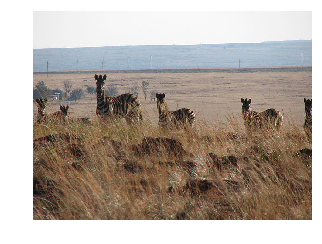

In [17]:
def apply_model_to_image_raw_bytes(raw):
    img = utils.decode_image_from_buf(raw)
    fig = plt.figure(figsize=(5, 5.5))
    plt.grid('off')
    plt.axis('off')
    plt.imshow(img)
    img = utils.crop_and_preprocess(img, (IMG_SIZE, IMG_SIZE), final_model.preprocess_for_model)
    print(' '.join(generate_caption(img)[1:-1]))
    plt.show()

def show_valid_example(val_img_fns, example_idx=0):
    zf = zipfile.ZipFile("val2014_sample.zip")
    all_files = set(val_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    apply_model_to_image_raw_bytes(zf.read(example))
    
show_valid_example(val_img_fns, example_idx=300)

/Users/jiahuiyuan/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


a young man wearing a hat and a hat


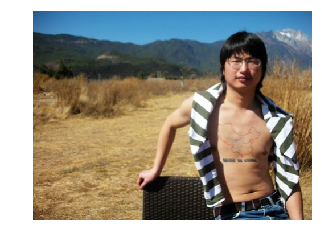

In [18]:
download_utils.download_file(
    "http://s3.sinaimg.cn/bmiddle/6e91fe21tx6BvL0fl6Oe2&690",
    "lizhi.jpg"
)
apply_model_to_image_raw_bytes(open("lizhi.jpg", "rb").read())

## Decoder Architecture -- GRU

In [19]:
tf.reset_default_graph()
tf.set_random_seed(1)
s = tf.InteractiveSession()

IMG_EMBED_SIZE = train_img_embeds.shape[1]
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
GRU_UNITS = 300
LOGIT_BOTTLENECK = 120
pad_idx = vocab[PAD]

/Users/jiahuiyuan/anaconda/lib/python3.6/site-packages/tensorflow/python/client/session.py:1720: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [20]:
class decoder:
    ### input placeholders ###
    img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
    sentences = tf.placeholder('int32', [None, None])
    
    ### image & embedding feature layers ###
    img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, 
                                      input_shape=(None, IMG_EMBED_SIZE), 
                                      activation='elu')
    img_embed_bottleneck_to_h0 = L.Dense(GRU_UNITS,
                                         input_shape=(None, IMG_EMBED_BOTTLENECK),
                                         activation='elu')
    word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)
    
    ### GRU cell structure ###
    gru = tf.nn.rnn_cell.GRUCell(GRU_UNITS)
    token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, 
                                      input_shape=(None, GRU_UNITS),
                                      activation="elu")
    token_logits = L.Dense(len(vocab),
                           input_shape=(None, LOGIT_BOTTLENECK))
    ### initial state ###
    h0 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds))
   
    # embed all tokens but the last for gru input
    word_embeds = word_embed(sentences[:,:-1])
    # hidden_states has a shape of [batch_size, time steps, GRU_UNITS].
    hidden_states, _ = tf.nn.dynamic_rnn(gru, word_embeds,
                                         initial_state=h0)

    ### compute token probs for all the hidden states ###
    flat_hidden_states = tf.reshape(hidden_states,[-1, GRU_UNITS])
    flat_token_logits = token_logits(token_logits_bottleneck(flat_hidden_states))
    flat_ground_truth = tf.reshape(sentences[:,1:],[-1,])
    
    flat_loss_mask = tf.not_equal(flat_ground_truth, pad_idx) #skip padding
    cros_ent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=flat_ground_truth, 
        logits=flat_token_logits
    )

    loss = tf.reduce_mean(tf.boolean_mask(cros_ent, flat_loss_mask))

In [21]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(decoder.loss)

saver = tf.train.Saver()

s.run(tf.global_variables_initializer())

/Users/jiahuiyuan/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## Training -- GRU

In [22]:
train_captions_indexed = np.array(train_captions_indexed)
val_captions_indexed = np.array(val_captions_indexed)

In [23]:
batch_size = 64
n_epochs = 20
n_batches_per_epoch = 1000
n_validation_batches = 100

In [24]:
MAX_LEN = 20

np.random.seed(123)
random.seed(123)

for epoch in range(n_epochs):
    
    train_loss = 0
    for batch in range(n_batches_per_epoch):
        train_loss += s.run([decoder.loss, train_step], 
                            generate_batch(train_img_embeds, 
                                           train_captions_indexed, 
                                           batch_size, 
                                           MAX_LEN))[0]
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    #save weights after finishing epoch
    #saver.save(s, os.path.abspath("weights_{}".format(epoch)))
    
print("Finished!")

Epoch: 0, train loss: 3.9535927369594575, val loss: 3.226244874000549
Epoch: 1, train loss: 3.015985412120819, val loss: 2.9461552715301513
Epoch: 2, train loss: 2.802088257789612, val loss: 2.8223902368545533
Epoch: 3, train loss: 2.695372206687927, val loss: 2.726623227596283
Epoch: 4, train loss: 2.6231269326210023, val loss: 2.6889260482788084
Epoch: 5, train loss: 2.5741267166137694, val loss: 2.6351227235794066
Epoch: 6, train loss: 2.541217453956604, val loss: 2.6125079202651977
Epoch: 7, train loss: 2.494486132144928, val loss: 2.5929301238059996
Epoch: 8, train loss: 2.4635311727523805, val loss: 2.5908616900444033
Epoch: 9, train loss: 2.4378862853050234, val loss: 2.583470461368561
Epoch: 10, train loss: 2.414762041091919, val loss: 2.552766511440277
Epoch: 11, train loss: 2.400285042285919, val loss: 2.530618276596069
Epoch: 12, train loss: 2.3792695150375365, val loss: 2.5283610343933107
Epoch: 13, train loss: 2.3610453677177428, val loss: 2.520664939880371
Epoch: 14, trai

In [25]:
saver.save(s, os.path.abspath("weights_gru"))

'/Users/jiahuiyuan/Desktop/1008 project/Xception/weights_gru'

## Applying model -- GRU

In [26]:
class final_model:
    # CNN encoder
    encoder, preprocess_for_model = get_cnn_encoder()
    saver.restore(s, os.path.abspath("weights_gru"))
    
    # containers for current gru states
    gru_h = tf.Variable(tf.zeros([1, GRU_UNITS]), name="hidden")

    # input images
    input_images = tf.placeholder('float32', [1, IMG_SIZE, IMG_SIZE, 3], name='images')
    img_embeds = encoder(input_images)

    # initialize gru state conditioned on image
    init_h = decoder.img_embed_bottleneck_to_h0(decoder.img_embed_to_bottleneck(img_embeds))
    init_gru = tf.assign(gru_h, init_h)
    
    current_word = tf.placeholder('int32', [1], name='current_input')
    word_embed = decoder.word_embed(current_word)

    new_h = decoder.gru(word_embed, gru_h)[1]
    new_logits = decoder.token_logits(decoder.token_logits_bottleneck(new_h))
    new_probs = tf.nn.softmax(new_logits)

    # outputs probabilities of next token and updates gru hidden state
    one_step = new_probs, tf.assign(gru_h, new_h)

INFO:tensorflow:Restoring parameters from /Users/jiahuiyuan/Desktop/1008 project/Xception/weights_gru


In [27]:
#if sample=True, we sample next token from the predicted probability distribution
def generate_caption(image, t=1, sample=False, max_len=20):
    # condition gru on the image
    s.run(final_model.init_gru, 
          {final_model.input_images: [image]})
    
    caption = [vocab[START]]
    
    for _ in range(max_len):
        next_word_probs = s.run(final_model.one_step, 
                                {final_model.current_word: [caption[-1]]})[0]
        next_word_probs = next_word_probs.ravel()
        next_word_probs = next_word_probs**(1/t) / np.sum(next_word_probs**(1/t))

        if sample:
            next_word = np.random.choice(range(len(vocab)), p=next_word_probs)
        else:
            next_word = np.argmax(next_word_probs)

        caption.append(next_word)
        if next_word == vocab[END]:
            break
       
    return list(map(vocab_inverse.get, caption))

/Users/jiahuiyuan/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


a group of zebras standing in a field


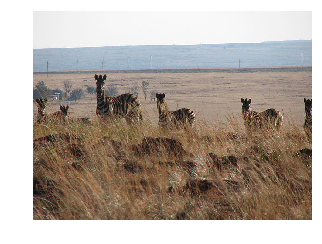

In [28]:
def apply_model_to_image_raw_bytes(raw):
    img = utils.decode_image_from_buf(raw)
    fig = plt.figure(figsize=(5, 5.5))
    plt.grid('off')
    plt.axis('off')
    plt.imshow(img)
    img = utils.crop_and_preprocess(img, (IMG_SIZE, IMG_SIZE), final_model.preprocess_for_model)
    print(' '.join(generate_caption(img)[1:-1]))
    plt.show()

def show_valid_example(val_img_fns, example_idx=0):
    zf = zipfile.ZipFile("val2014_sample.zip")
    all_files = set(val_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    apply_model_to_image_raw_bytes(zf.read(example))
    
show_valid_example(val_img_fns, example_idx=300)

/Users/jiahuiyuan/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


a man in a green shirt and a black tie


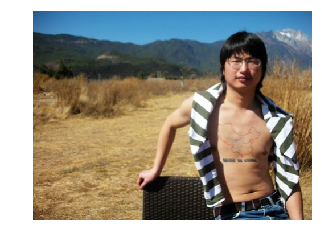

In [29]:
download_utils.download_file(
    "http://s3.sinaimg.cn/bmiddle/6e91fe21tx6BvL0fl6Oe2&690",
    "lizhi.jpg"
)
apply_model_to_image_raw_bytes(open("lizhi.jpg", "rb").read())

## Decoder Architecture -- Basic RNN

In [30]:
tf.reset_default_graph()
tf.set_random_seed(1)
s = tf.InteractiveSession()

/Users/jiahuiyuan/anaconda/lib/python3.6/site-packages/tensorflow/python/client/session.py:1720: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [31]:
IMG_EMBED_SIZE = train_img_embeds.shape[1]
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
RNN_UNITS = 300
LOGIT_BOTTLENECK = 120
pad_idx = vocab[PAD]

In [32]:
class decoder:
    ### input placeholders ###
    img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
    sentences = tf.placeholder('int32', [None, None])
    
    ### image & embedding feature layers ###
    img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, 
                                      input_shape=(None, IMG_EMBED_SIZE), 
                                      activation='elu')
    img_embed_bottleneck_to_h0 = L.Dense(RNN_UNITS,
                                         input_shape=(None, IMG_EMBED_BOTTLENECK),
                                         activation='elu')
    word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)
    
    ### RNN cell structure ###
    rnn = tf.nn.rnn_cell.BasicRNNCell(RNN_UNITS)
    token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, 
                                      input_shape=(None, RNN_UNITS),
                                      activation="elu")
    token_logits = L.Dense(len(vocab),
                           input_shape=(None, LOGIT_BOTTLENECK))
    ### initial state ###
    h0 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds))
   
    # embed all tokens but the last for rnn input
    word_embeds = word_embed(sentences[:,:-1])
    # hidden_states has a shape of [batch_size, time steps, RNN_UNITS].
    hidden_states, _ = tf.nn.dynamic_rnn(rnn, word_embeds,
                                         initial_state=h0)

    ### compute token probs for all the hidden states ###
    flat_hidden_states = tf.reshape(hidden_states,[-1, RNN_UNITS])
    flat_token_logits = token_logits(token_logits_bottleneck(flat_hidden_states))
    flat_ground_truth = tf.reshape(sentences[:,1:],[-1,])
    
    flat_loss_mask = tf.not_equal(flat_ground_truth, pad_idx) #skip padding
    cros_ent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=flat_ground_truth, 
        logits=flat_token_logits
    )

    loss = tf.reduce_mean(tf.boolean_mask(cros_ent, flat_loss_mask))

In [33]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(decoder.loss)

saver = tf.train.Saver()

s.run(tf.global_variables_initializer())

/Users/jiahuiyuan/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## Training -- Basic RNN

In [34]:
train_captions_indexed = np.array(train_captions_indexed)
val_captions_indexed = np.array(val_captions_indexed)

In [35]:
batch_size = 64
n_epochs = 20
n_batches_per_epoch = 1000
n_validation_batches = 100

In [36]:
MAX_LEN = 20

np.random.seed(123)
random.seed(123)

for epoch in range(n_epochs):
    
    train_loss = 0
    for batch in range(n_batches_per_epoch):
        train_loss += s.run([decoder.loss, train_step], 
                            generate_batch(train_img_embeds, 
                                           train_captions_indexed, 
                                           batch_size, 
                                           MAX_LEN))[0]
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    #save weights after finishing epoch
    #saver.save(s, os.path.abspath("weights_{}".format(epoch)))
    
print("Finished!")

Epoch: 0, train loss: 4.4683898093700405, val loss: 3.9794247555732727
Epoch: 1, train loss: 3.7524233634471895, val loss: 3.538004500865936
Epoch: 2, train loss: 3.35463809967041, val loss: 3.2794150805473326
Epoch: 3, train loss: 3.1681207060813903, val loss: 3.1391427183151244
Epoch: 4, train loss: 3.0549113256931304, val loss: 3.0714506244659425
Epoch: 5, train loss: 2.9819501237869264, val loss: 2.9959343314170837
Epoch: 6, train loss: 2.9408998012542726, val loss: 2.950963816642761
Epoch: 7, train loss: 2.8832659986019133, val loss: 2.912771542072296
Epoch: 8, train loss: 2.8459942874908446, val loss: 2.904239783287048
Epoch: 9, train loss: 2.8156118438243865, val loss: 2.8964357948303223
Epoch: 10, train loss: 2.7935719091892244, val loss: 2.8472846484184267
Epoch: 11, train loss: 2.7820752642154694, val loss: 2.833642203807831
Epoch: 12, train loss: 2.755081898212433, val loss: 2.8156769466400147
Epoch: 13, train loss: 2.732178936243057, val loss: 2.800633466243744
Epoch: 14, t

In [37]:
saver.save(s, os.path.abspath("weights_rnn"))

'/Users/jiahuiyuan/Desktop/1008 project/Xception/weights_rnn'

## Applying model -- Basic RNN

In [38]:
class final_model:
    # CNN encoder
    encoder, preprocess_for_model = get_cnn_encoder()
    saver.restore(s, os.path.abspath("weights_rnn"))
    
    # containers for current rnn states
    rnn_h = tf.Variable(tf.zeros([1, RNN_UNITS]), name="hidden")

    # input images
    input_images = tf.placeholder('float32', [1, IMG_SIZE, IMG_SIZE, 3], name='images')
    img_embeds = encoder(input_images)

    # initialize rnn state conditioned on image
    init_h = decoder.img_embed_bottleneck_to_h0(decoder.img_embed_to_bottleneck(img_embeds))
    init_rnn = tf.assign(rnn_h, init_h)
    
    current_word = tf.placeholder('int32', [1], name='current_input')
    word_embed = decoder.word_embed(current_word)

    new_h = decoder.rnn(word_embed, rnn_h)[1]
    new_logits = decoder.token_logits(decoder.token_logits_bottleneck(new_h))
    new_probs = tf.nn.softmax(new_logits)

    # outputs probabilities of next token and updates rnn hidden state
    one_step = new_probs, tf.assign(rnn_h, new_h)

INFO:tensorflow:Restoring parameters from /Users/jiahuiyuan/Desktop/1008 project/Xception/weights_rnn


In [39]:
#if sample=True, we sample next token from the predicted probability distribution
def generate_caption(image, t=1, sample=False, max_len=20):
    # condition rnn on the image
    s.run(final_model.init_rnn, 
          {final_model.input_images: [image]})
    
    caption = [vocab[START]]
    
    for _ in range(max_len):
        next_word_probs = s.run(final_model.one_step, 
                                {final_model.current_word: [caption[-1]]})[0]
        next_word_probs = next_word_probs.ravel()
        next_word_probs = next_word_probs**(1/t) / np.sum(next_word_probs**(1/t))

        if sample:
            next_word = np.random.choice(range(len(vocab)), p=next_word_probs)
        else:
            next_word = np.argmax(next_word_probs)

        caption.append(next_word)
        if next_word == vocab[END]:
            break
       
    return list(map(vocab_inverse.get, caption))

/Users/jiahuiyuan/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


a herd of zebras standing in a field


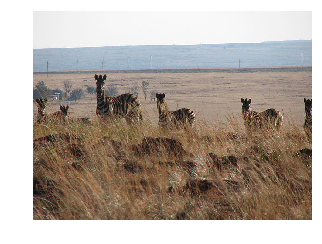

In [40]:
def apply_model_to_image_raw_bytes(raw):
    img = utils.decode_image_from_buf(raw)
    fig = plt.figure(figsize=(5, 5.5))
    plt.grid('off')
    plt.axis('off')
    plt.imshow(img)
    img = utils.crop_and_preprocess(img, (IMG_SIZE, IMG_SIZE), final_model.preprocess_for_model)
    print(' '.join(generate_caption(img)[1:-1]))
    plt.show()

def show_valid_example(val_img_fns, example_idx=0):
    zf = zipfile.ZipFile("val2014_sample.zip")
    all_files = set(val_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    apply_model_to_image_raw_bytes(zf.read(example))
    
show_valid_example(val_img_fns, example_idx=300)

/Users/jiahuiyuan/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


a man in a bikini holding a frisbee


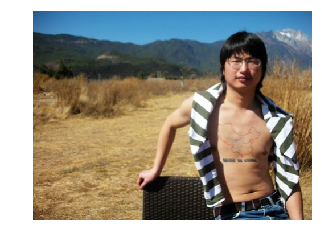

In [41]:
download_utils.download_file(
    "http://s3.sinaimg.cn/bmiddle/6e91fe21tx6BvL0fl6Oe2&690",
    "lizhi.jpg"
)
apply_model_to_image_raw_bytes(open("lizhi.jpg", "rb").read())